In [56]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys



In [57]:
def ldaLearn(X, y):

    class_labels = np.unique(y)
    d = X.shape[1]
    k = len(class_labels)

    means = np.zeros((d, k))

    for i, label in enumerate(class_labels):
        class_data = X[y.flatten() == label]
        means[:, i] = np.mean(class_data, axis=0)

    covmat = np.cov(X.T, bias=True)

    return means, covmat



In [58]:
def qdaLearn(X, y):
    class_labels = np.unique(y)
    d = X.shape[1]
    k = len(class_labels)

    means = np.zeros((d, k))
    covmats = []

    for i, label in enumerate(class_labels):
        class_data = X[y.flatten() == label]
        means[:, i] = np.mean(class_data, axis=0)
        covmats.append(np.cov(class_data.T, bias=True))  # d x d for each class

    return means, covmats


In [59]:
def ldaTest(means, covmat, Xtest, ytest):
    inv_cov = np.linalg.inv(covmat)
    k = means.shape[1]
    n = Xtest.shape[0]
    scores = np.zeros((n, k))
    for i in range(k):
        diff = Xtest - means[:, i].reshape(1, -1)
        scores[:, i] = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)

    ypred = np.argmax(scores, axis=1).reshape(-1, 1) + 1
    acc = np.mean(ypred == ytest) * 100
    return acc, ypred


In [42]:
def qdaTest(means, covmats, Xtest, ytest):
    k = means.shape[1]
    n = Xtest.shape[0]

    scores = np.zeros((n, k))
    for i in range(k):
        diff = Xtest - means[:, i].reshape(1, -1)
        inv_cov = np.linalg.inv(covmats[i])
        det_cov = np.linalg.det(covmats[i])
        scores[:, i] = -0.5 * np.sum(diff @ inv_cov * diff, axis=1) - 0.5 * np.log(det_cov + 1e-6)

    ypred = np.argmax(scores, axis=1).reshape(-1, 1) + 1
    acc = np.mean(ypred == ytest) * 100
    return acc, ypred

In [43]:
def learnOLERegression(X,y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1

    # IMPLEMENT THIS METHOD
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

In [44]:
def learnRidgeRegression(X, y, lambd):
    # Inputs:
    # X - N x d matrix (N examples, d features)
    # y - N x 1 vector of target values
    # lambd - scalar regularization parameter
    #
    # Output:
    # w - d x 1 weight vector (ridge regression weights)

    I = np.identity(X.shape[1])  # Identity matrix of size d x d
    w = np.linalg.inv(X.T @ X + lambd * I) @ X.T @ y
    return w

In [45]:
def testOLERegression(w, Xtest, ytest):
    # Inputs:
    # w - d x 1 weight vector
    # Xtest - N x d test input matrix
    # ytest - N x 1 true output vector
    #
    # Output:
    # mse - scalar Mean Squared Error on test data

    y_pred = Xtest @ w
    mse = np.mean((ytest - y_pred) ** 2)
    return mse


In [46]:
def regressionObjVal(w, X, y, lambd):
    # Inputs:
    # w - weight vector flattened (d,)
    # X - N x d input matrix
    # y - N x 1 output vector
    # lambd - regularization parameter
    #
    # Outputs:
    # error - scalar regularized loss value
    # error_grad - gradient of error w.r.t. w (flattened)

    w = w.reshape(-1, 1)  # Convert to column vector
    error = 0.5 * np.sum((y - X @ w) ** 2) + 0.5 * lambd * np.sum(w ** 2)
    error_grad = -X.T @ (y - X @ w) + lambd * w
    return error, error_grad.flatten()


In [47]:
def mapNonLinear(x, p):
    # Inputs:
    # x - N x 1 column vector (single feature)
    # p - highest power to expand to (integer >= 0)
    #
    # Output:
    # Xp - N x (p+1) matrix [1, x, x^2, ..., x^p]

    x = x.flatten() #
    N = x.shape[0]
    Xp = np.ones((N, p + 1))
    for i in range(1, p + 1):
        Xp[:, i] = x[:, 0] ** i
    return Xp



Problem 1:

In [48]:
# Main script

# Problem 1
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')



In [49]:
# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))



LDA Accuracy = 97.0
QDA Accuracy = 96.0


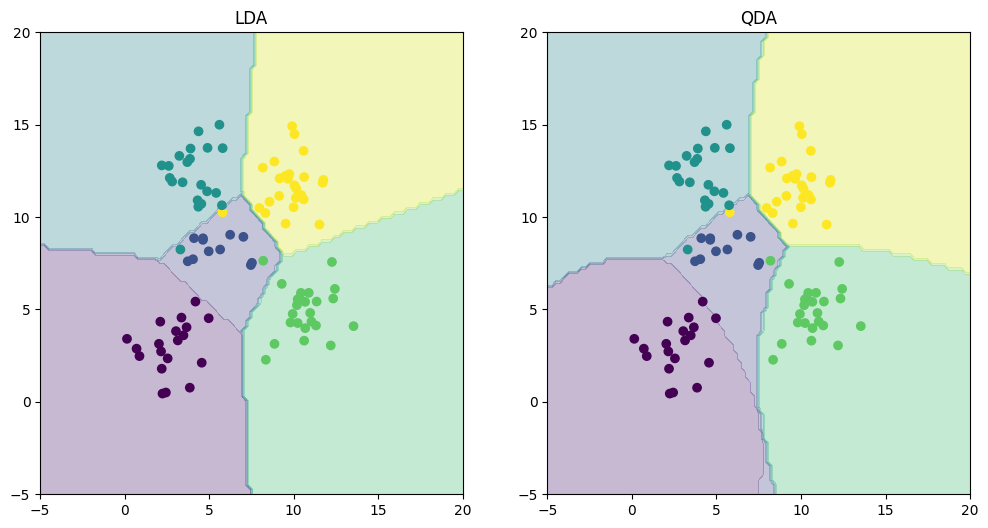

In [50]:
# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)
plt.title('QDA')

plt.show()

PROBLEM -2

In [51]:
# Problem 2

if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

MSE without intercept 106775.36156418786
MSE with intercept 3707.8401812458424


PROBLEM -3


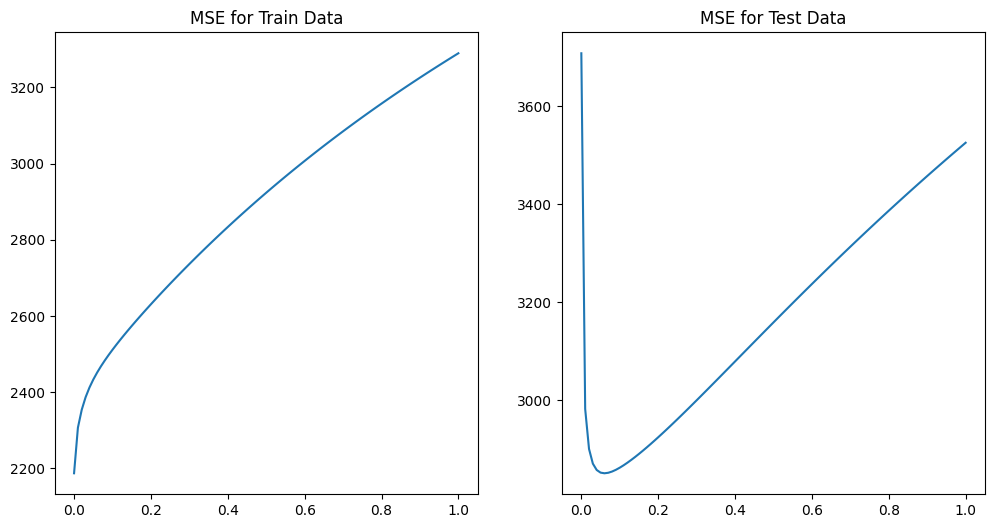

Optimal lambda: 0.06


In [52]:

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

lambda_opt = lambdas[np.argmin(mses3)]
print("Optimal lambda:", lambda_opt)


PROBLEM 4

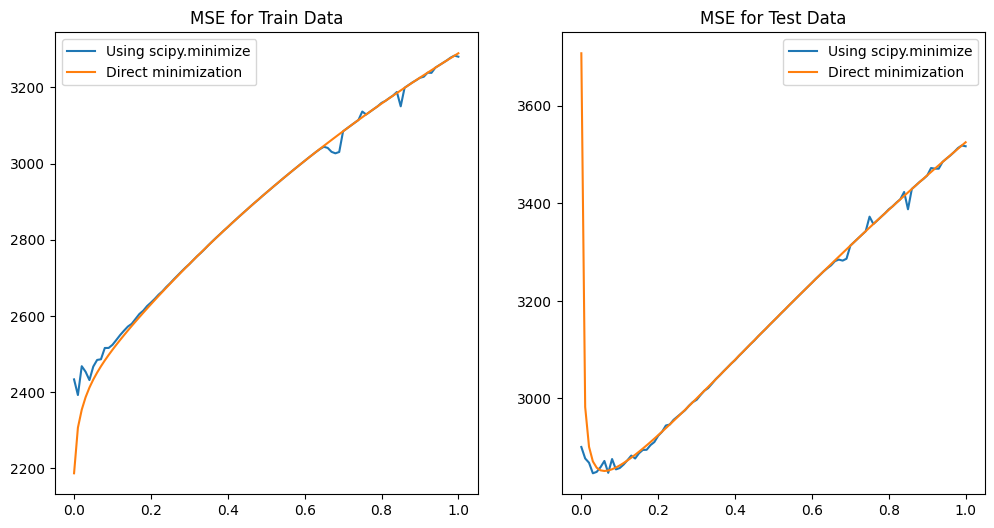

In [53]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.
w_init = np.ones(X_i.shape[1]) # Changed to a 1D array
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

PROBLEM 5


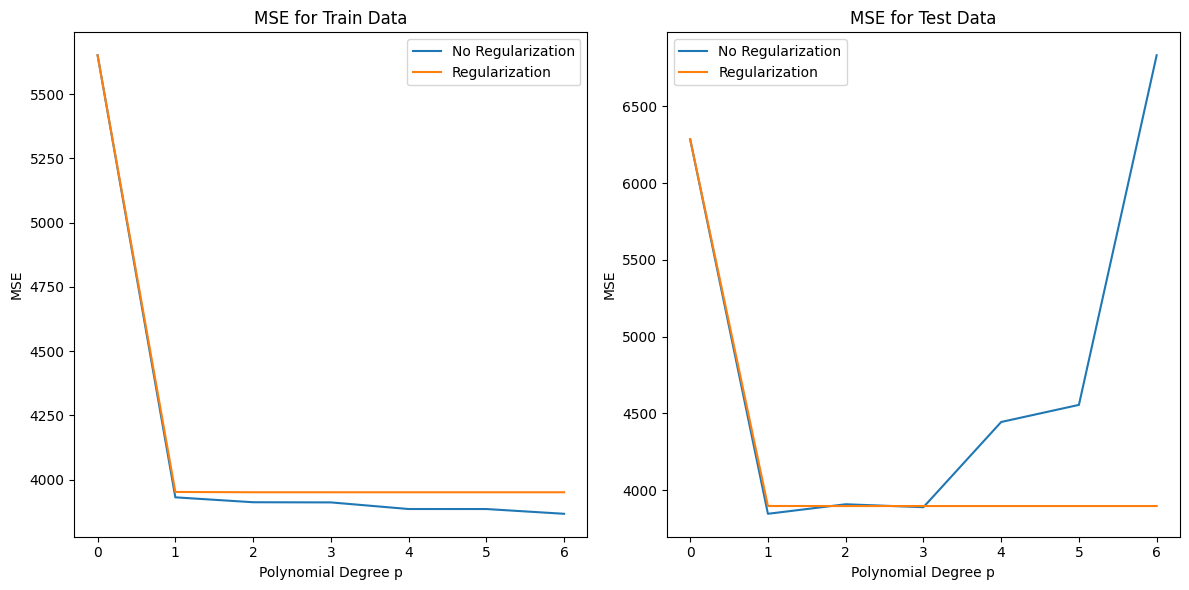

In [55]:
# Problem 5

def mapNonLinear(x, p):

    if len(x.shape) == 1:  # x is 1D, shape (N,)
        x = x.reshape(-1, 1)  # making  it (N,1)
    N = x.shape[0]
    Xp = np.ones((N, p + 1))
    for i in range(1, p + 1):
        Xp[:, i] = x[:, 0] ** i
    return Xp

# Problem 5 Code
pmax = 7
lambda_opt = 0.06  # Optimal lambda from Problem 3

mses5_train = np.zeros((pmax, 2))  # Column 0 = no reg, Column 1 = with reg
mses5 = np.zeros((pmax, 2))
for p in range(pmax):
    Xd = mapNonLinear(X[:, 2], p)
    Xdtest = mapNonLinear(Xtest[:, 2], p)
    w_d1 = learnRidgeRegression(Xd, y, 0)
    mses5_train[p, 0] = testOLERegression(w_d1, Xd, y)
    mses5[p, 0] = testOLERegression(w_d1, Xdtest, ytest)
    w_d2 = learnRidgeRegression(Xd, y, lambda_opt)
    mses5_train[p, 1] = testOLERegression(w_d2, Xd, y)
    mses5[p, 1] = testOLERegression(w_d2, Xdtest, ytest)

fig = plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax), mses5_train)
plt.title('MSE for Train Data')
plt.xlabel('Polynomial Degree p')
plt.ylabel('MSE')
plt.legend(('No Regularization', 'Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax), mses5)
plt.title('MSE for Test Data')
plt.xlabel('Polynomial Degree p')
plt.ylabel('MSE')
plt.legend(('No Regularization', 'Regularization'))
plt.tight_layout()
plt.show()
